# Исследование причин убытков развлекательного приложения

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания-разработчик развлекательного приложения терпит убытки. 

**Цель исследования:** разобраться в причинах образования убытков у разработчика развлекательного приложения.

**Задачи исследования:** 

- определить пригодность исходных данных для дальнейшего анализа, провести предобработку данных;
- задать функции для расчёта и анализа LTV, ROI, удержания и конверсии;
- составить профили пользователей и определить период привлечения пользователей;
- определить распределение пользователей по странам, устройствам и каналам привлечения;
- рассчитать траты на маркетинг, в том числе показатель CAC;
- на основе графиков LTV, ROI и CAC, проанализировать окупаемость рекламы. 

## Краткие выводы по результатам анализа

Анализируемый период привлечения пользователей - с 01.05.2019 по 27.10.2019. 

В датафрейме содержатся данные о пользователях:
- из четырех стран - США (большинство пользователей), Великобритания, Франция и Германия;
- использующих устройства iPhone (большинство), Android, Mac и PC. 

При распределении пользователей по каналам привлечения нет линейной зависимости между количеством привлеченных пользователей и плательщиков: наибольшее количество пользователей пришло в приложение органическим путем, однако наибольшее количество платящих пользователей было привлечено через FaceBoom.

Анализ маркетинговых данных показал, что высокие затраты на канал привлечения TipTop (более 50% от всех затрат) приносят лишь коло 13% пользователей (с учетом органически пришедших пользователей) или около 21% (без их учета). Динамика расходов понедельно, помесячно, показатель CAC показывают, что расходы на маркетинг по каналу TipTop крайне высоки, а также имеют тенденцию к быстрому росту, при том, что никакие данные не свидетельствуют об эффективности расходования таких больших средств на данный канал привлечения.

В целом, рекламная комания не окупается по причине высоких затрат на привлечение пользователей по отдельным устройствам (iPhone и Mac), странам (США) и каналам привлечения (TipTop).

Рекомендуется рассмотреть возможность сокращения рекламных компаний на дорогих каналах (TipTop) и их расширения на каналах, недорогих по привлечению пользователей, но имеющих показатель ROI выше 1, например, lambdaMediaAds и YRabbit. Также стоит разобраться, нет ли технических причин, из-за которых пользователи из США, а также пользователи Mac и iPhone хорошо конвертируются в пользователей приложения, но быстро уходят. 

## Обзор и предобработка данных

Импортируем необходимые для проведения анализа данных библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import numpy as np
import seaborn as sns
import json

Прочитаем файлы `orders_info_short.csv`, `costs_info_short.csv` и `visits_info_short.csv` с данными (путь к данным храниться в файлах формата json) и сохраним их в соответствующих переменных `orders`, `ad_costs`, `visits`:

In [2]:
# Чтение JSON файла
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
    
# Чтение данных 
dataset_path_app_orders = config['dataset_path_app_orders']
dataset_path_app_costs = config['dataset_path_app_costs']
dataset_path_app_visits = config['dataset_path_app_visits']
orders = pd.read_csv(dataset_path_app_orders)
ad_costs = pd.read_csv(dataset_path_app_costs)
visits = pd.read_csv(dataset_path_app_visits)

Уберем ограничения при отображении количества столбцов, строк, ширины столбцов.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Выведем первые строки наборов данных и общую информацию о датафреймах.

In [4]:
# Функция для вывода первых 5 строк и информации о датафрейме
def display_data(df, df_name):
    print(f"Первые 5 строк датафрейма {df_name}:\n")
    print(df.head(5).to_string())
    print("\nИнформация о датафрейме:\n")
    print(df.info())
    print("\n" + "="*80 + "\n")

# Основная функция для вывода данных 
def main():
    display_data(orders, 'orders')
    display_data(ad_costs, 'ad_costs')
    display_data(visits, 'visits')

# Запускаем основную функцию
main()

Первые 5 строк датафрейма orders:

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


Первые 5 строк датафрейма ad_costs:

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>


В первую очередь, приведем заголовки столбцов к нижнему регистру:

In [5]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
ad_costs.columns = ad_costs.columns.str.lower()

Затем устраним пробелы в наименованиях столбцов, заменив их нижним подчеркиванием:

In [6]:
def replace_spaces(column_name):
    return column_name.replace(' ', '_')

visits.rename(columns=replace_spaces, inplace=True)
orders.rename(columns=replace_spaces, inplace=True)
ad_costs.rename(columns=replace_spaces, inplace=True)

Пропусков в данных нет, однако необходимо привести столбцы с данными, содержащие дату и время, к формату `datetime`:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

Проверим наличие явных дубликатов в датафреймах:

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
ad_costs.duplicated().sum()

0

Явные дубликаты среди строк датафреймов отсутствуют. 

В целом, данные для анализа полные и не требуют дальнейшей предобработки: пропусков данных нет, столбцы, содержащие дату и время, приведены к формату `datetime`.

## Исследовательский анализ данных

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии

Зададим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**get_profiles()** - функция для создания пользовательских профилей:

In [11]:
def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'region': 'first',
                'device': 'first',
                'channel': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**get_retention()** - функция для подсчета удержания Retention Rate:

In [12]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**get_conversion()** — функция для подсчёта конверсии:

In [13]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

**get_ltv()** — функция для подсчёта LTV:

In [14]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

**filter_data()** — функция для сглаживания данных:

In [15]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

**plot_retention()** — функция для построения графика Retention Rate:

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**plot_conversion()** — функция для построения графика конверсии:

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**plot_ltv_roi()** — функция для визуализации LTV и ROI:

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Составление профилей пользователей

Вызовем функцию `get_profiles()`, передав ей данные о посещениях, покупках и тратах на рекламу компании.

In [19]:
profiles = get_profiles(visits, orders, ad_costs)
profiles.head(5)

user_id            first_ts         region  device     channel  \
0    599326 2019-05-07 20:58:57  United States     Mac    FaceBoom   
1   4919697 2019-07-09 12:46:07  United States  iPhone    FaceBoom   
2   6085896 2019-10-01 09:58:33         France  iPhone     organic   
3  22593348 2019-08-22 21:35:48        Germany      PC  AdNonSense   
4  31989216 2019-10-02 00:07:44  United States  iPhone     YRabbit   

           dt    month  payer  acquisition_cost  
0  2019-05-07  2019-05   True          1.088172  
1  2019-07-09  2019-07  False          1.107237  
2  2019-10-01  2019-10  False          0.000000  
3  2019-08-22  2019-08  False          0.988235  
4  2019-10-02  2019-10  False          0.230769

Определим минимальную дату привлечения пользователей:

In [20]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

И максимальную:

In [21]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Минимальная и максимальная даты привлечения пользователей - 01.05.2019 и 27.10.2019, что совпадает с исходными данными по проекту.

### Распределение пользователей по странам

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей: 

In [22]:
# Определяем количество пользователей с разбивкой по странам
users_by_country = profiles.pivot_table(
    index = ['region'], 
    values = ['user_id'], 
    aggfunc ='count'
).rename(columns={'user_id': 'users_count'})

# Определяем количество платящих пользователей по странам
users_by_country_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['region'], 
    values=['user_id'], 
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Объединяем две таблицы
merged_table = users_by_country.merge(users_by_country_payers, on='region', how='left')
sorted_table = merged_table.sort_values(by='payers_count', ascending=False)

# Добавляем стобец с долей платящих пользователей с разбивкой по странам
sorted_table['payers_share'] = sorted_table['payers_count']/sorted_table['users_count']*100
sorted_table['payers_share'] = sorted_table['payers_share'].round(2)
sorted_table

users_count  payers_count  payers_share
region                                                
United States       100002          6902          6.90
UK                   17575           700          3.98
France               17450           663          3.80
Germany              14981           616          4.11

Визуализируем получившиеся данные: построим таблицу, отражающую  общее количество пользователей и количество платящих из каждой страны.

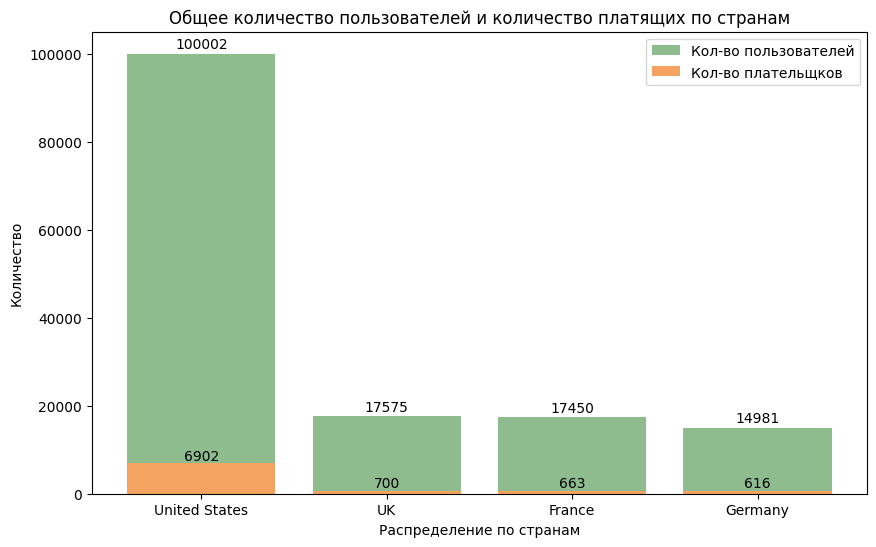

In [23]:
# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 6))

# Определение ширины столбцов
bar_width = 0.8

# Построение столбца users_count
ax.bar(sorted_table.index, 
       sorted_table['users_count'], 
       color='darkseagreen', 
       label='Кол-во пользователей')

# Построение столбца payers_count внутри users_count
ax.bar(sorted_table.index, 
       sorted_table['payers_count'], 
       color='sandybrown', 
       label='Кол-во плательщков', 
       width=bar_width)

# Настройка отображения легенды
ax.legend()

# Добавление подписей к столбцам
for i, v in enumerate(sorted_table['users_count']):
    ax.text(i, v + 500, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Настройка осей и заголовка
ax.set_xlabel('Распределение по странам')
ax.set_ylabel('Количество')
ax.set_title('Общее количество пользователей и количество платящих по странам')

# Отображение диаграммы
plt.show()

Как наибольшее число пользователей в целом, так и платящих пользователей приходится на США.

### Распределение пользователей по устройствам

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 

In [24]:
# Определяем количество пользователей с разбивкой по используемым устройствам
users_by_device = profiles.pivot_table(
    index = ['device'], 
    values = ['user_id'], 
    aggfunc ='count'
).rename(columns={'user_id': 'users_count'})

# Определяем количество платящих пользователей с разбивкой по используемым устройствам
users_by_device_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['device'], 
    values=['user_id'], 
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Объединяем две таблицы
merged_table_2 = users_by_device.merge(users_by_device_payers, on='device', how='left')
sorted_table_2 = merged_table_2.sort_values(by='payers_count', ascending=False)

# Добавляем стобец с долей платящих пользователей с разбивкой по устройствам
sorted_table_2['payers_share'] = sorted_table_2['payers_count']/sorted_table_2['users_count']*100
sorted_table_2['payers_share'] = sorted_table_2['payers_share'].round(2)
sorted_table_2

users_count  payers_count  payers_share
device                                          
iPhone         54479          3382          6.21
Android        35032          2050          5.85
Mac            30042          1912          6.36
PC             30455          1537          5.05

Построим таблицу, отражающую общее количество пользователей и количество платящих пользователей для каждого устройства.

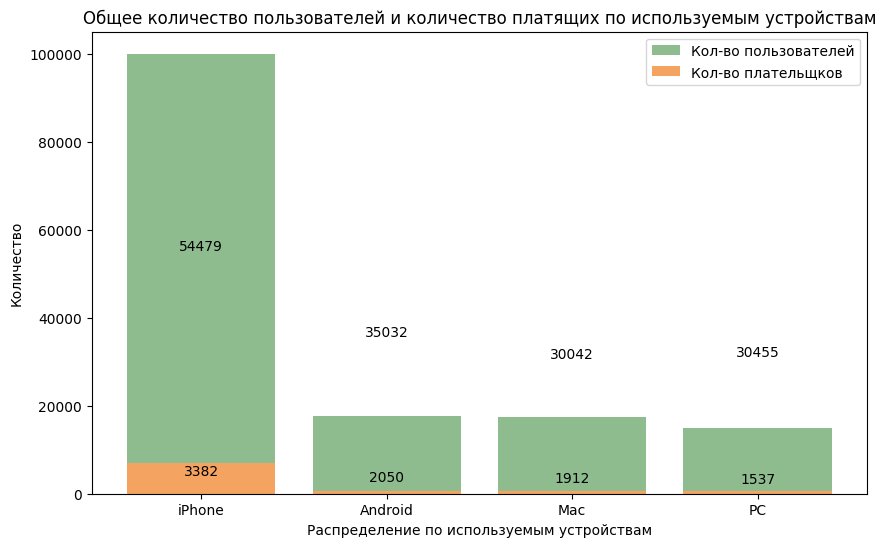

In [25]:
# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 6))

# Определение ширины столбцов
bar_width = 0.8

# Построение столбца users_count
ax.bar(sorted_table_2.index, sorted_table['users_count'], color='darkseagreen', label='Кол-во пользователей')

# Построение столбца payers_count внутри users_count
ax.bar(sorted_table_2.index, sorted_table['payers_count'], color='sandybrown', label='Кол-во плательщков', width=bar_width)

# Настройка отображения легенды
ax.legend()

# Добавление подписей к столбцам
for i, v in enumerate(sorted_table_2['users_count']):
    ax.text(i, v + 200, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table_2['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Настройка осей и заголовка
ax.set_xlabel('Распределение по используемым устройствам')
ax.set_ylabel('Количество')
ax.set_title('Общее количество пользователей и количество платящих по используемым устройствам')

# Отображение диаграммы
plt.show()

Клиенты используют четыре вида устройств - iPhone, Android, Mac и PC. Наибольшее количество как пользователей в целом, так и плательщиков в частности используют iPhone.

### Каналы привлечения пользователей

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [26]:
# Определяем количество пользователей с разбивкой по каналам привлечения 
users_by_channel = profiles.pivot_table(
    index = ['channel'], 
    values = ['user_id'], 
    aggfunc ='count'
).rename(columns={'user_id': 'users_count'})

# Определяем количество платящих пользователей с разбивкой по каналам привлечения 
users_by_channel_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['channel'], 
    values=['user_id'], 
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Объединяем две таблицы
merged_table_3 = users_by_channel.merge(users_by_channel_payers, on='channel', how='left')
sorted_table_3 = merged_table_3.sort_values(by='payers_count', ascending=False)

# Добавляем стобец с долей платящих пользователей с разбивкой по каналам привлечения
sorted_table_3['payers_share'] = sorted_table_3['payers_count']/sorted_table_3['users_count']*100
sorted_table_3['payers_share'] = sorted_table_3['payers_share'].round(2)
sorted_table_3

# Определяем функцию для выделения столбца цветом
def highlight_column(s):
    return ['background-color: darkseagreen' if col == 'payers_count' else '' for col in s.index]

# Применяем стиль к датафрейму
styled_table = sorted_table_3.style.apply(highlight_column, axis=1)

# Выводим стилизованную таблицу
styled_table

Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

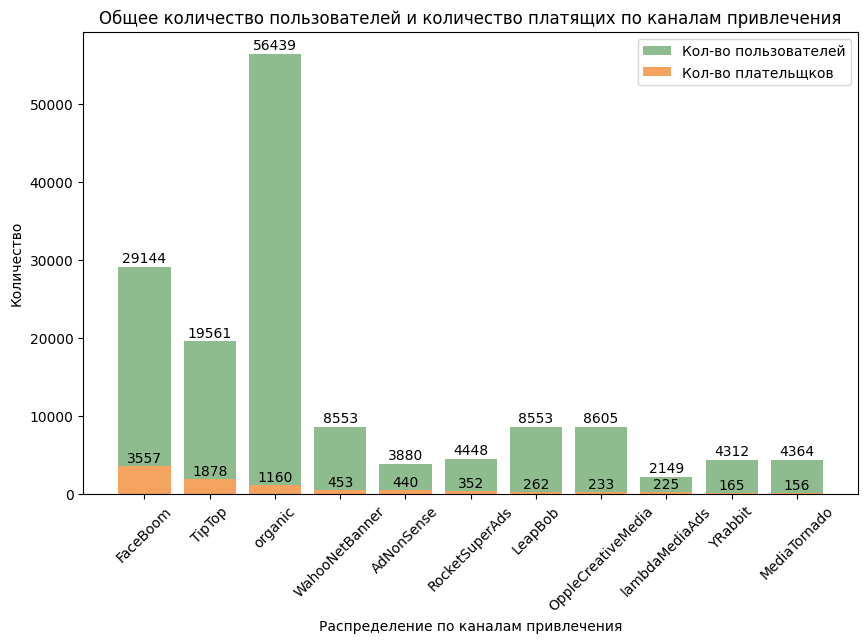

In [27]:
# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 6))

# Определение ширины столбцов
bar_width = 0.8

# Построение столбца users_count
ax.bar(sorted_table_3.index, sorted_table_3['users_count'], color='darkseagreen', label='Кол-во пользователей')

# Построение столбца payers_count внутри users_count
ax.bar(sorted_table_3.index, sorted_table_3['payers_count'], color='sandybrown', label='Кол-во плательщков', width=bar_width)

# Настройка отображения легенды
ax.legend()

# Добавление подписей к столбцам
for i, v in enumerate(sorted_table_3['users_count']):
    ax.text(i, v + 200, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table_3['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Настройка осей и заголовка
ax.set_xlabel('Распределение по каналам привлечения')
ax.set_ylabel('Количество')
ax.set_title('Общее количество пользователей и количество платящих по каналам привлечения')

# Поворот подписей по оси x
plt.xticks(rotation=45)

# Отображение диаграммы
plt.show()

В отличие от распределения по странам и устройствам в распределении по каналам привлечения нет линейной зависимости между количеством пользователей в целом и количеством платящих пользователей. Например, самое большое количество пользователей в целом пришло органическим путем, но среди плательщиков органические пользователи занимают только третье место. На втором месте по количеству привлеченных пользователей FaceBoom, но именно этот канал приводит в продукт наибольшее количество платящей аудитории.

Можно сделать вывод о том, что анализируемый период привлечения пользователей - с 01.05.2019 по 27.10.2019. Пользователи неравномерно распределены по 4 странам - США, Великобритания, Франция и Германия. Наибольшее количество как пользователей в целом, так и платящих пользователей - из США. Распределение пользователей в заисимости от типа используемого устройства также является неравномерным, с подавляющей долей как пользователей в целом, так и платящих пользователей, использующих iPhone. Среди других устройств - Android, Mac и PC. При распределении пользователей по каналам привлечения нет линейной зависимости между количеством привлеченных пользователей и плательщиков: наибольшее количество пользователей в целом пришло в приложение органическим путем (по количеству плательщиков - 3 место), наибольшее количество платящих пользователей было привлечено через FaceBoom (по количеству всех привлеченных пользователей - 2 место). 

## Маркетинг

### Общая сумма расходов на маркетинг

In [28]:
# Выведем общую сумму расходов на маркетинг
(ad_costs['costs'].sum()).round(2)

105497.3

### Распределение затрат по рекламным источникам

In [29]:
# Определяем объемы затрат с разбивкой по каналам привлечения 
costs_by_channel = ad_costs.pivot_table(
    index = ['channel'], 
    values = ['costs'], 
    aggfunc ='sum')
costs_by_channel = costs_by_channel.sort_values(by = 'costs', ascending = False)
costs_by_channel

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

### Динамика изменения расходов во времени по неделям по каждому источнику

In [30]:
# Добавляем в датафрейм ad_costs столбец с номером недели
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']) 
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week

# Формируем таблицу с данными о сумме рекламных расходов с разбивкой по каналам привлечения и неделям
ad_costs_by_week = ad_costs.groupby(['week', 'channel'])['costs'].sum().reset_index()  
ad_costs_by_week.round(2).head(5)

week             channel   costs
0    18          AdNonSense  211.05
1    18            FaceBoom  535.70
2    18             LeapBob   16.80
3    18        MediaTornado   38.64
4    18  OppleCreativeMedia   24.00

Визуализируем полученные в таблице выше данные:

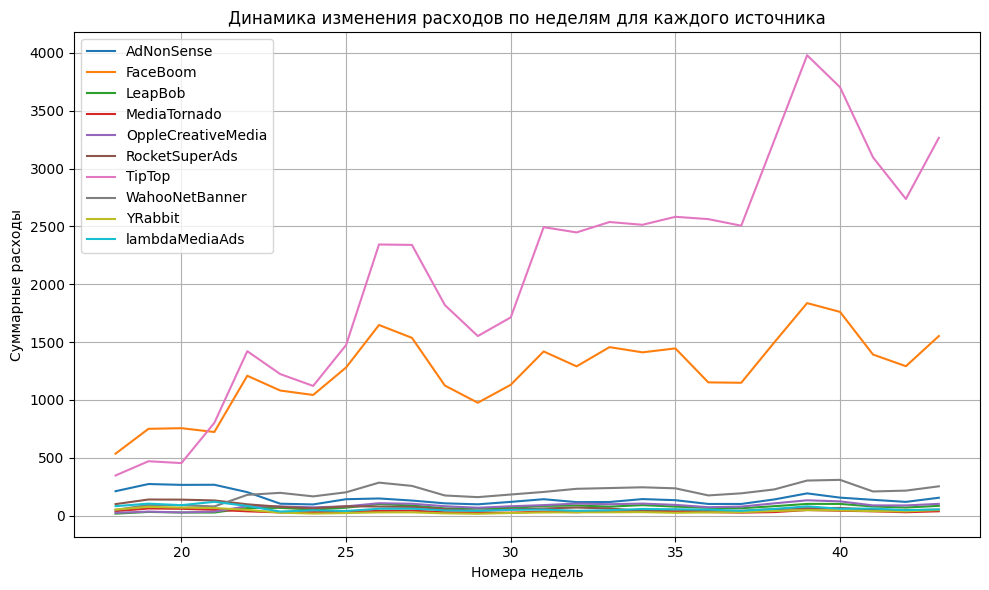

In [31]:
# Построение графика
plt.figure(figsize=(10, 6))

# Группировка данных по каналам и построение линейного графика для каждого канала
for channel, data in ad_costs_by_week.groupby('channel'):
    plt.plot(data['week'], data['costs'], label=channel)

# Добавление легенды и подписей к осям
plt.legend()
plt.xlabel('Номера недель')
plt.ylabel('Суммарные расходы')
plt.title('Динамика изменения расходов по неделям для каждого источника')

# Отображение графика
plt.grid(True)
plt.tight_layout()
plt.show()

Резко выделяются два источника с высокими затрататами на маркетинг - TipTop и FaceBoom. Причем на диаграмме видно, что затраты на эти каналы привлечения не только превышают затраты по всем прочим каналам, но и показывают тенденцию к непрерывному росту. 

### Динамика изменения расходов во времени по месяцам по каждому источнику

In [32]:
# Добавляем в датафрейм ad_costs столбец с номером месяца
ad_costs['month'] = ad_costs['dt'].dt.month

# Формируем таблицу с данными о сумме рекламных расходов с разбивкой по каналам привлечения и месяцам
ad_costs_by_month = ad_costs.groupby(['month', 'channel'])['costs'].sum().reset_index()  
ad_costs_by_month.round(2).head(5)

month             channel    costs
0      5          AdNonSense  1169.70
1      5            FaceBoom  3524.40
2      5             LeapBob   140.28
3      5        MediaTornado   238.56
4      5  OppleCreativeMedia   169.75

Визуализируем полученные в таблице выше данные:

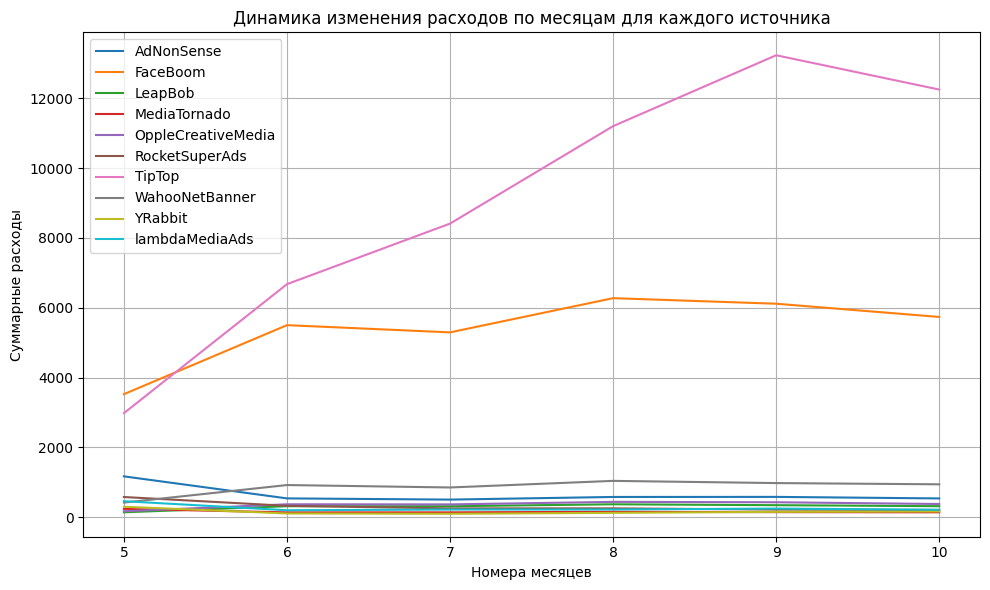

In [33]:
# Построение графика
plt.figure(figsize=(10, 6))

# Группировка данных по каналам и построение линейного графика для каждого канала
for channel, data in ad_costs_by_month.groupby('channel'):
    plt.plot(data['month'], data['costs'], label=channel)

# Добавление легенды и подписей к осям
plt.legend()
plt.xlabel('Номера месяцев')
plt.ylabel('Суммарные расходы')
plt.title('Динамика изменения расходов по месяцам для каждого источника')

# Отображение графика
plt.grid(True)
plt.tight_layout()
plt.show()

На данном графике, как и на графике, отражающем разбивку по неделям, видно, что значительно больших затрат по сравнению с другими требуют два канала привлечения - TipTop и FaceBoom. При этом для FaceBoom характерен небольшой рост расходов (начиная с июня расходы колеблются в пределах одной суммы), а расходы на TipTop резко растут, достигая в сентябре колоссального пика. 

### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника

In [49]:
# Формируем сводную таблицу с информацией о сумме расходов по каналам
accost_by_channel = profiles.pivot_table(index = ['channel'], values = ['acquisition_cost'], aggfunc = 'sum')
accost_by_channel = accost_by_channel.rename(columns={'acquisition_cost': 'acquisition_cost_agg'})

# Определяем количество пользователей в разрезе каналов привлечения 
users_by_channel = profiles.pivot_table(index = ['channel'], values = ['user_id'], aggfunc = 'count')
users_by_channel = users_by_channel.rename(columns={'user_id': 'users_count'})

# Объединяем две таблицы
accost_by_channel = accost_by_channel.merge(users_by_channel, on=['channel'], how='left')

# Рассчитываем среднюю стоимость привлеечения одного пользователя (CAC) по каждому источнику
accost_by_channel['mean_cac'] = accost_by_channel['acquisition_cost_agg']/accost_by_channel['users_count']

# Сортируем данные по среднему значению CAC
accost_by_channel= accost_by_channel.sort_values(by='mean_cac', ascending=False)
accost_by_channel

# Определяем функцию для выделения столбца цветом
def highlight_column(s):
    return ['background-color: darkseagreen' if col == 'mean_cac' else '' for col in s.index]

# Применяем стиль и форматирование к датафрейму 
styled_table = accost_by_channel.style.apply(highlight_column, axis=1).format({
    'acquisition_cost_agg': '{:.2f}', 
    'mean_cac': '{:.2f}'
})

# Выводим стилизованную таблицу
styled_table

Средняя стоимость привлечения одного пользователя через TipTop более чем в два раза превышает аналогичное значение для второго по дороговизне канала привлечения FaceBoom. 

По результатам оценки маркетинговых данных можно сделать вывод о том, что при общем размере затрат почти в 105 500, больше половины затрат - около 55 000 приходится на канал TipTop. При этом данный канал обеспечивает привлечение всего лишь около 13% пользователей (с учетом органически пришедших пользователей) или около 21% (без их учета). Для сравнения канал FaceBoom привлекает около 31% пользователей (без учета органически пришедших), в то время как маркетинговые затраты для данного канала не превышают 30%. Все исследованные показатели - динамика расходов понедельно, помесячно, CAC показывают, что расходы на маркетинг по каналу TipTop крайне высоки, а также имеют тенденцию к быстрому росту, при том, что никакие данные не свидетельствуют об эффективности расходования таких больших средств на данный канал привлечения. 

## Оценка окупаемости рекламы

### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI

Установим момент и горизонт анализа данных:

In [35]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Поскольку пользователи, пришедшие в приложение органически, генерируют нулевые маркетинговые затраты, исключим их из дальнейшего анализа:

In [36]:
profiles_2 = profiles.loc[profiles['channel'] != 'organic']
visits_2 = visits.loc[visits['channel'] != 'organic']

Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`.

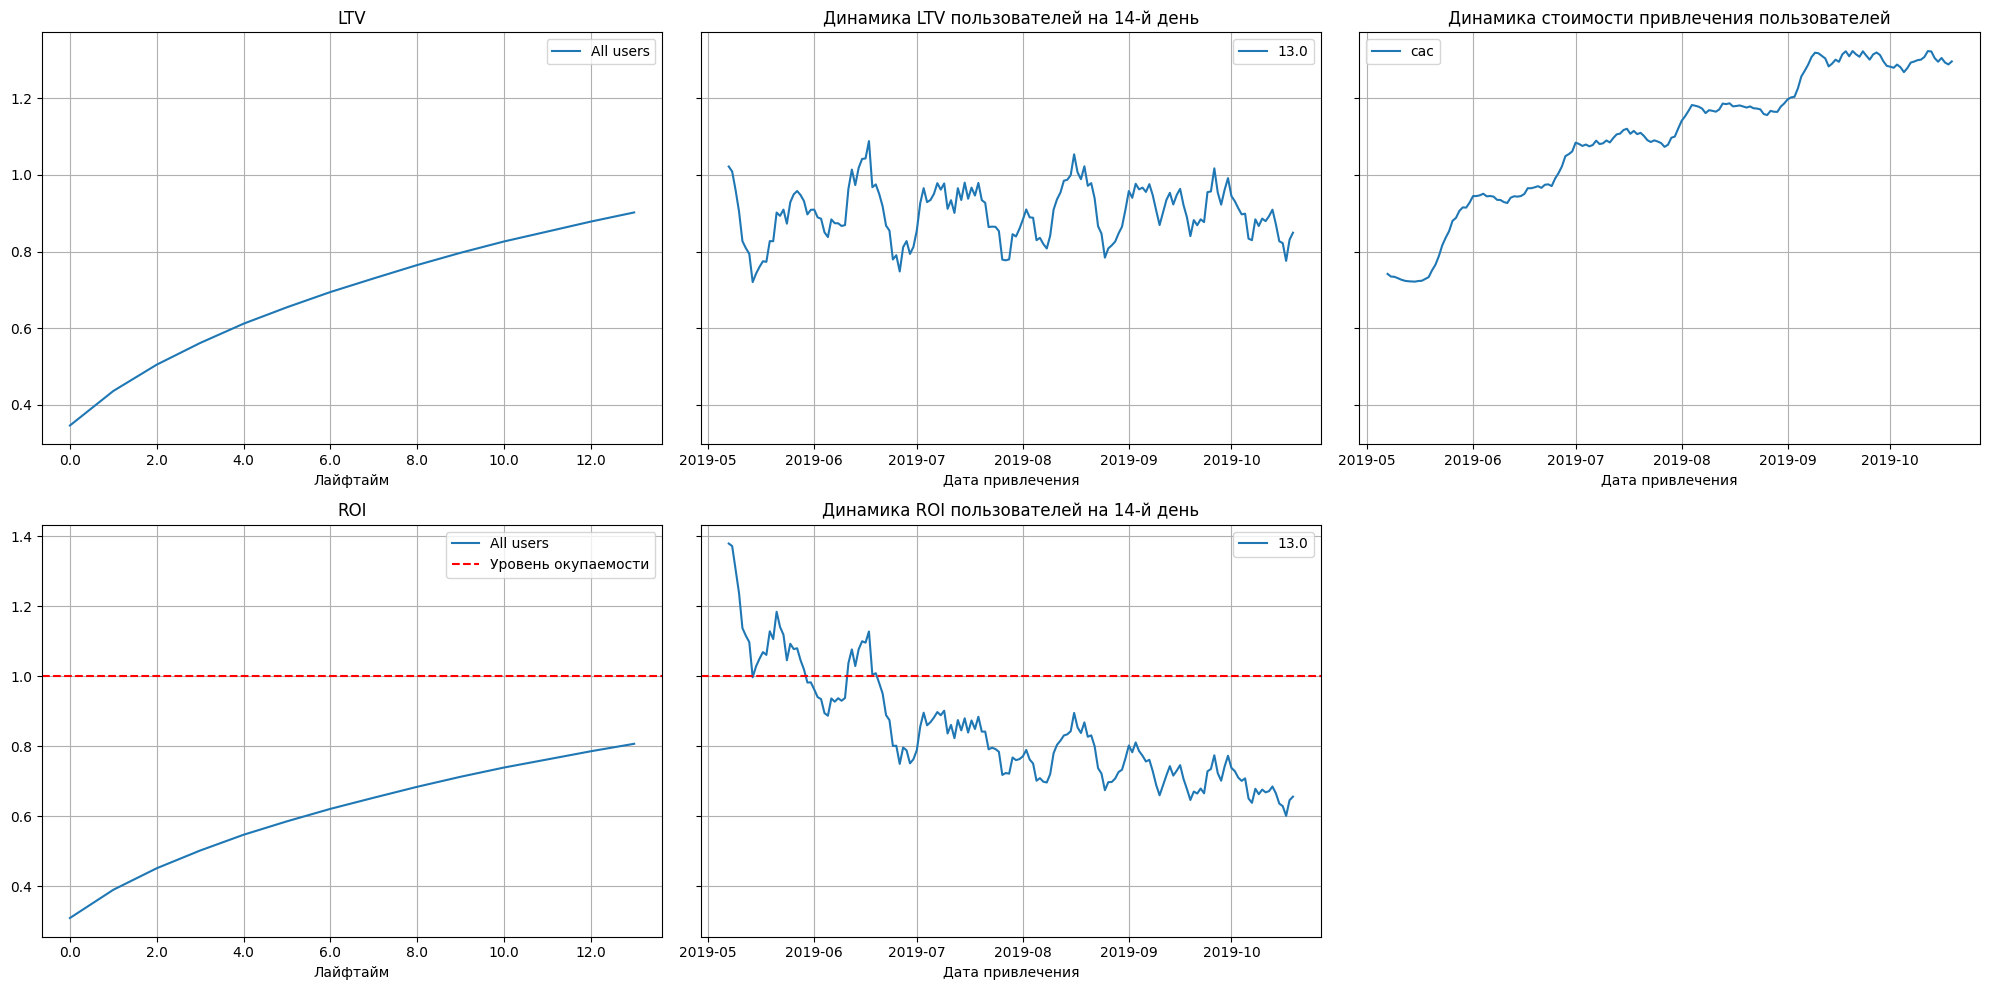

In [37]:
# Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

В целом видны помесячные колебания показателя LTV, однако он стабильно растет с течением времени. Показатель ROI также растет, однако скорость его роста значительно ниже, чем у показателя LTV. На момент наблюдения затраты на рекламу еще не окупились, поскольку показатель ROI не достиг уровня окупаемости. Причина видна в резком увеличении стоимости привлечения пользователей начиная уже с июня 2019 года, которое замедлилось в последующие месяцы, однако все равно сохранило тенденцию к стабильному росту. По графику динамики ROI на 14 день видно, что пользователи, привлеченные начиная с июня 2019 года, не приносят прибыли (предположительно из-за высоких затрат на маркетинг для их привлечения).

### Конверсия и удержание пользователей в моменте и в динамике

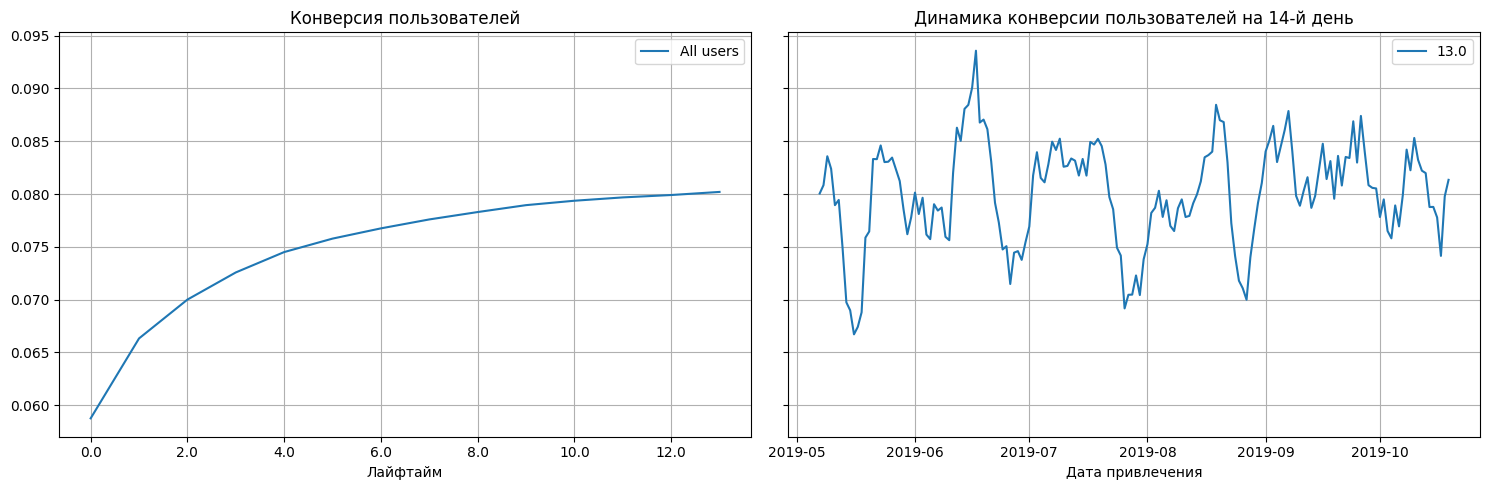

In [38]:
# Визуализируем конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Показатель конверсии непрерывно растет, динамика показателя повторяет тренд динамики LTV. 

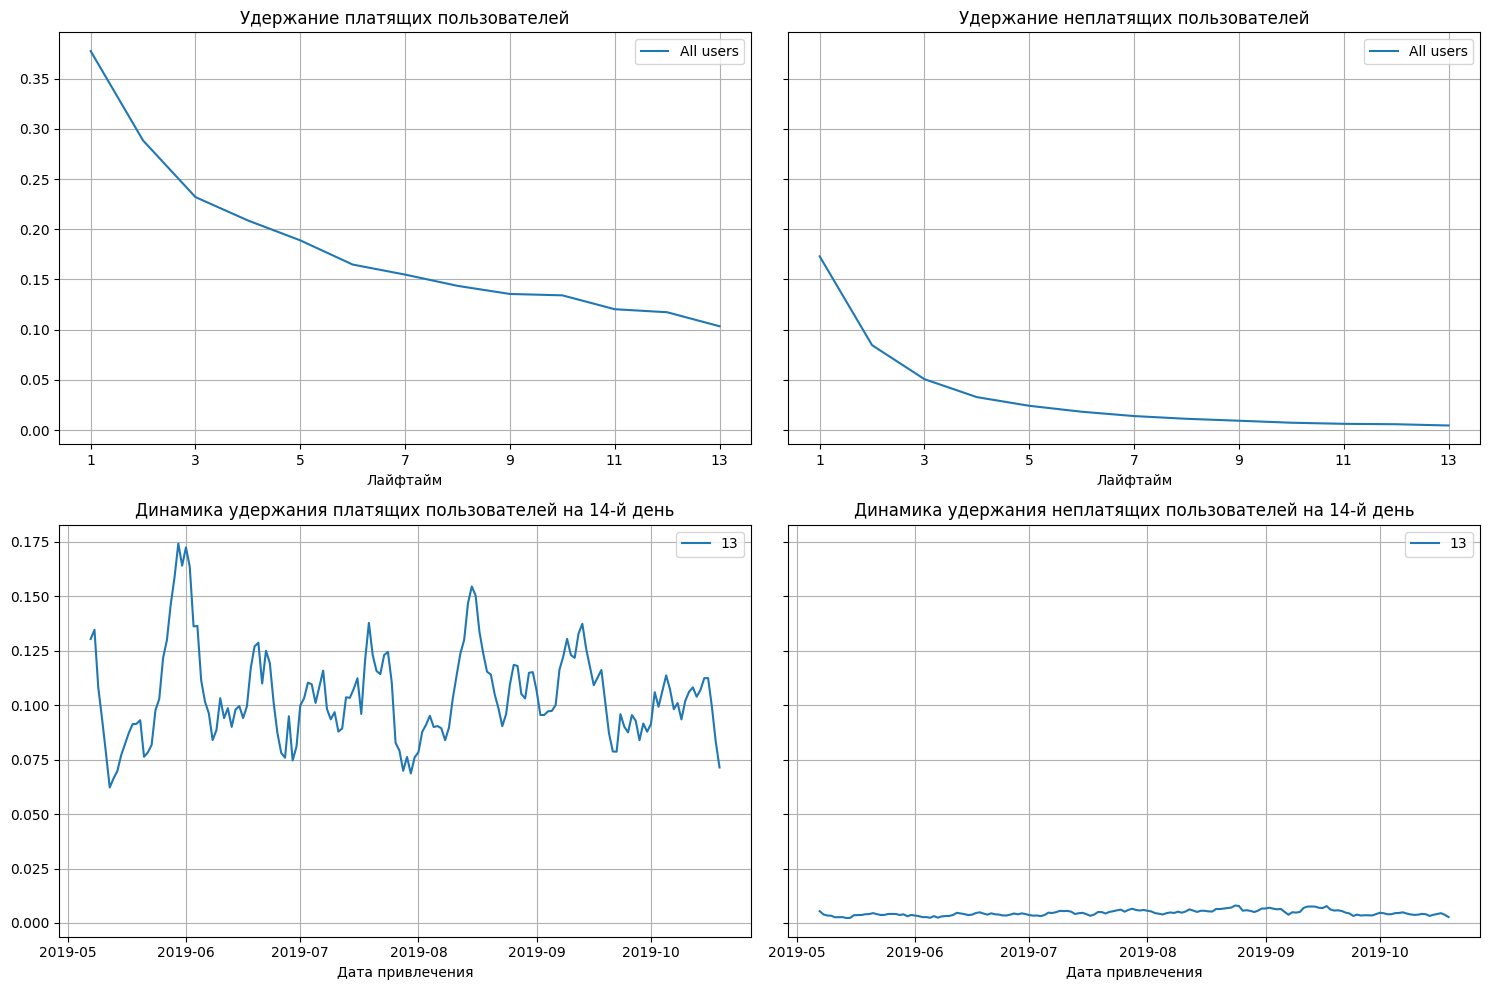

In [39]:
# Визуализируем удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей стабильно снижается с течением времени, при этом, платящие пользователи предсказуемо удерживаются лучше, чем неплатящие. Однако снижение удержания достаточно резкое как для тех, так и для других. Никакой особой динамики в снижении удержания пользователей в зависимости от времени их привлечения не выявлено: здесь только стоит отметить, что платящие пользователи, привлеченные в начале исследуемого периода, отличались чуть большим значением параметра удержания, чем привлеченные позднее. 

### Окупаемость рекламы с разбивкой по устройствам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

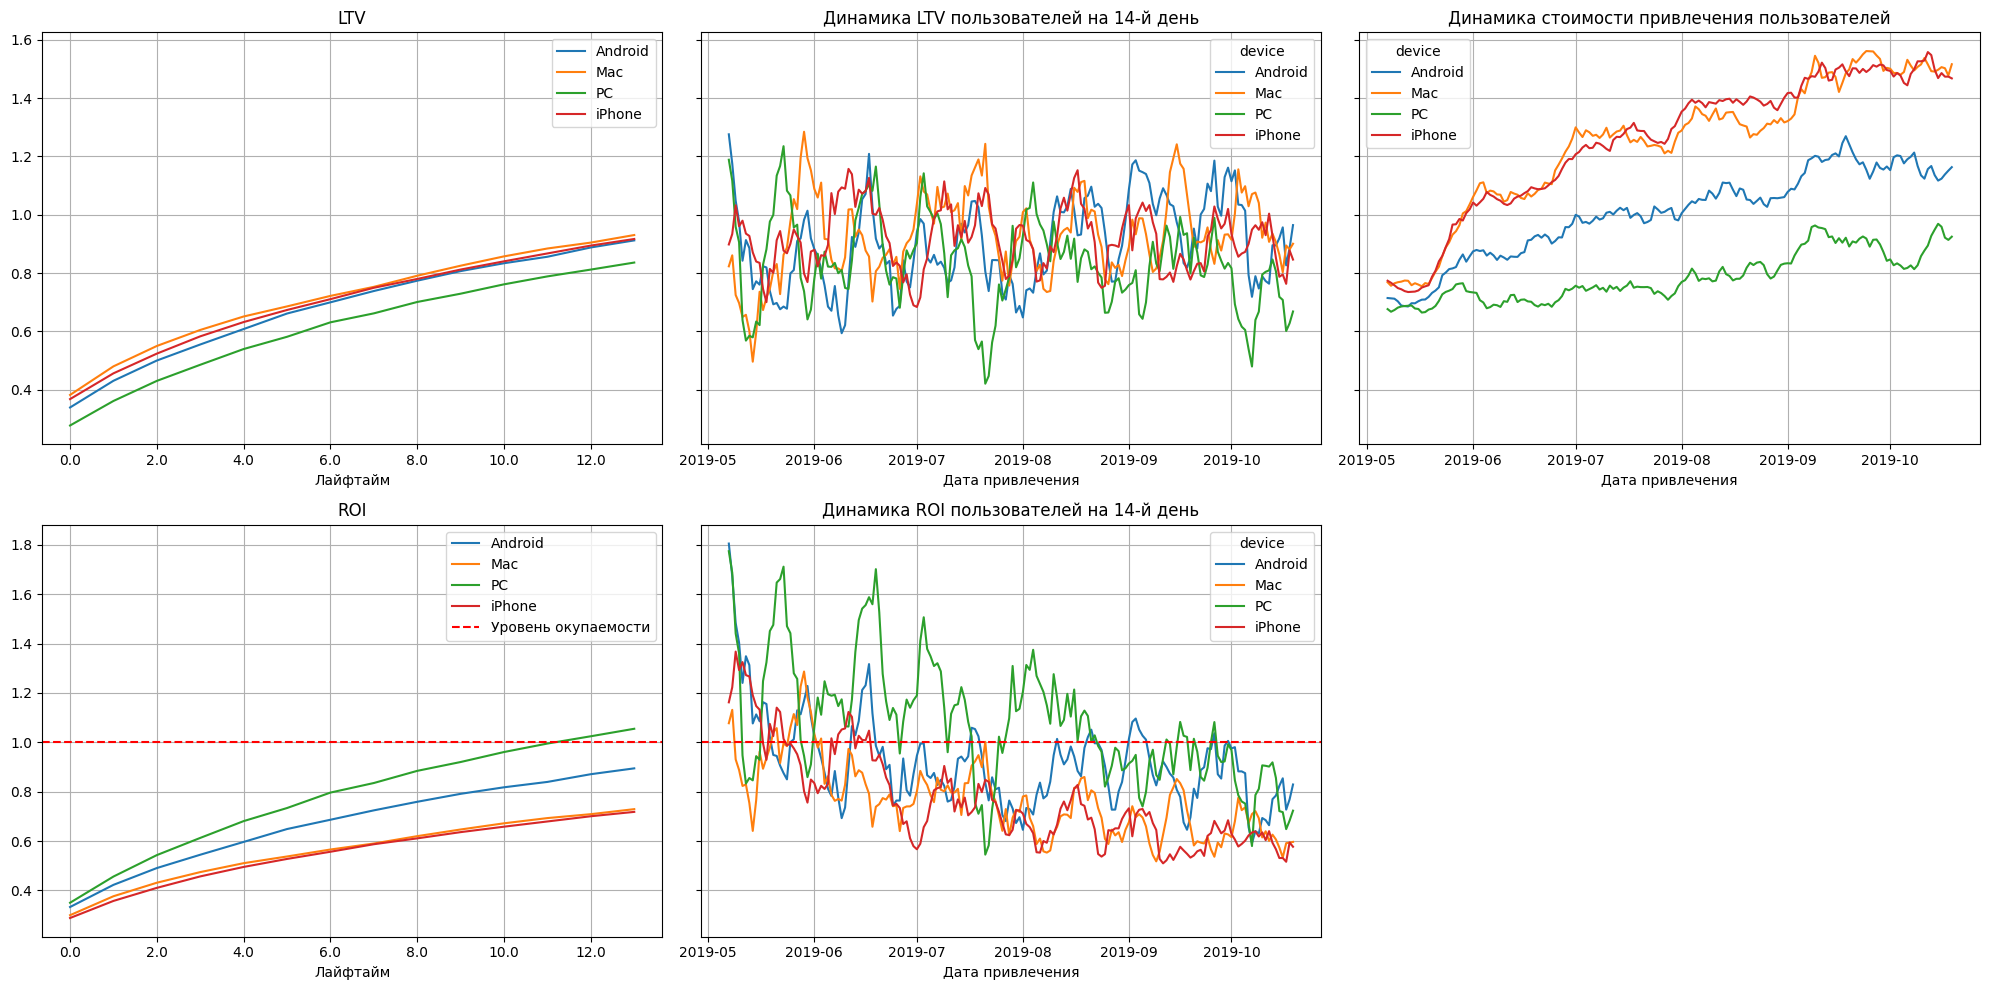

In [40]:
# Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['device']
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Несмотря на то, что пользователи с устройств Mac, iPhone и Android приносят больше прибыли, по показателю ROI они не выходят на уровень окупаемости, в отличие от пользователей PC. Причина в резком росте стоимости привлечения пользователей Mac, iPhone и Android. Таблица "Динамика ROI пользователей" показывает, что привлечение пользователей Mac, iPhone и Android перестало окупаться уже в июле, однако для пользователей PC динамика также отрицательная и если не исправить ситуацию, привлечение этих пользователей уже в ближайшее время также перестанет приносить прибыль (при условии сохранения текущих тенденций роста CAC). 

### Окупаемость рекламы с разбивкой по странам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

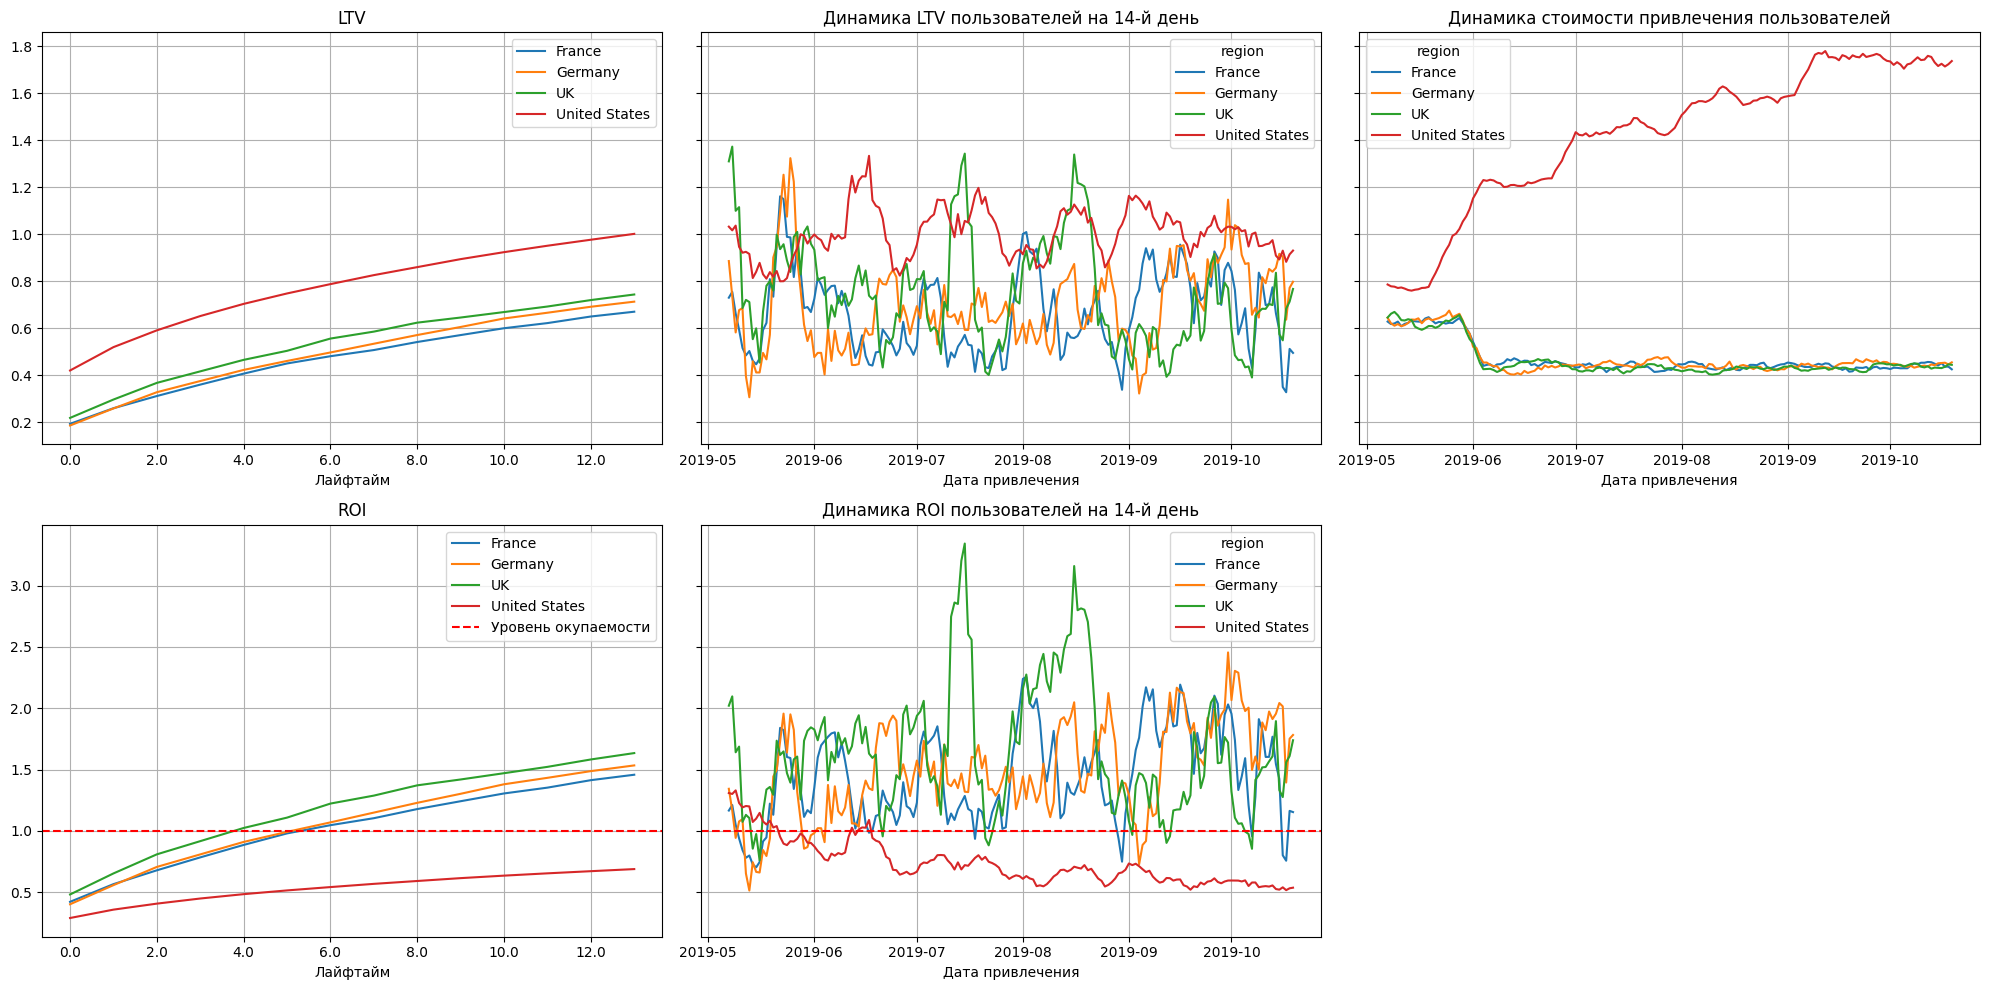

In [41]:
# Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['region']
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

При разбивке по странам ситуация аналогична разбивке по устройствам: пользователи из США приносят наибольшее количество дохода, однако из-за невероятно высокой стоимости привлечения данной категории клиентов по рынку США не удается выйти на уровень окупаемости. В динамике пользователи из США перестали приносить доход приблизительно с июля. Также можно провести параллель между показателями пользователей iPhone и Mac и пользователями из США, где преимущественно используются данные устройства. 

### Окупаемость рекламы с разбивкой по каналам привлечения пользователей

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

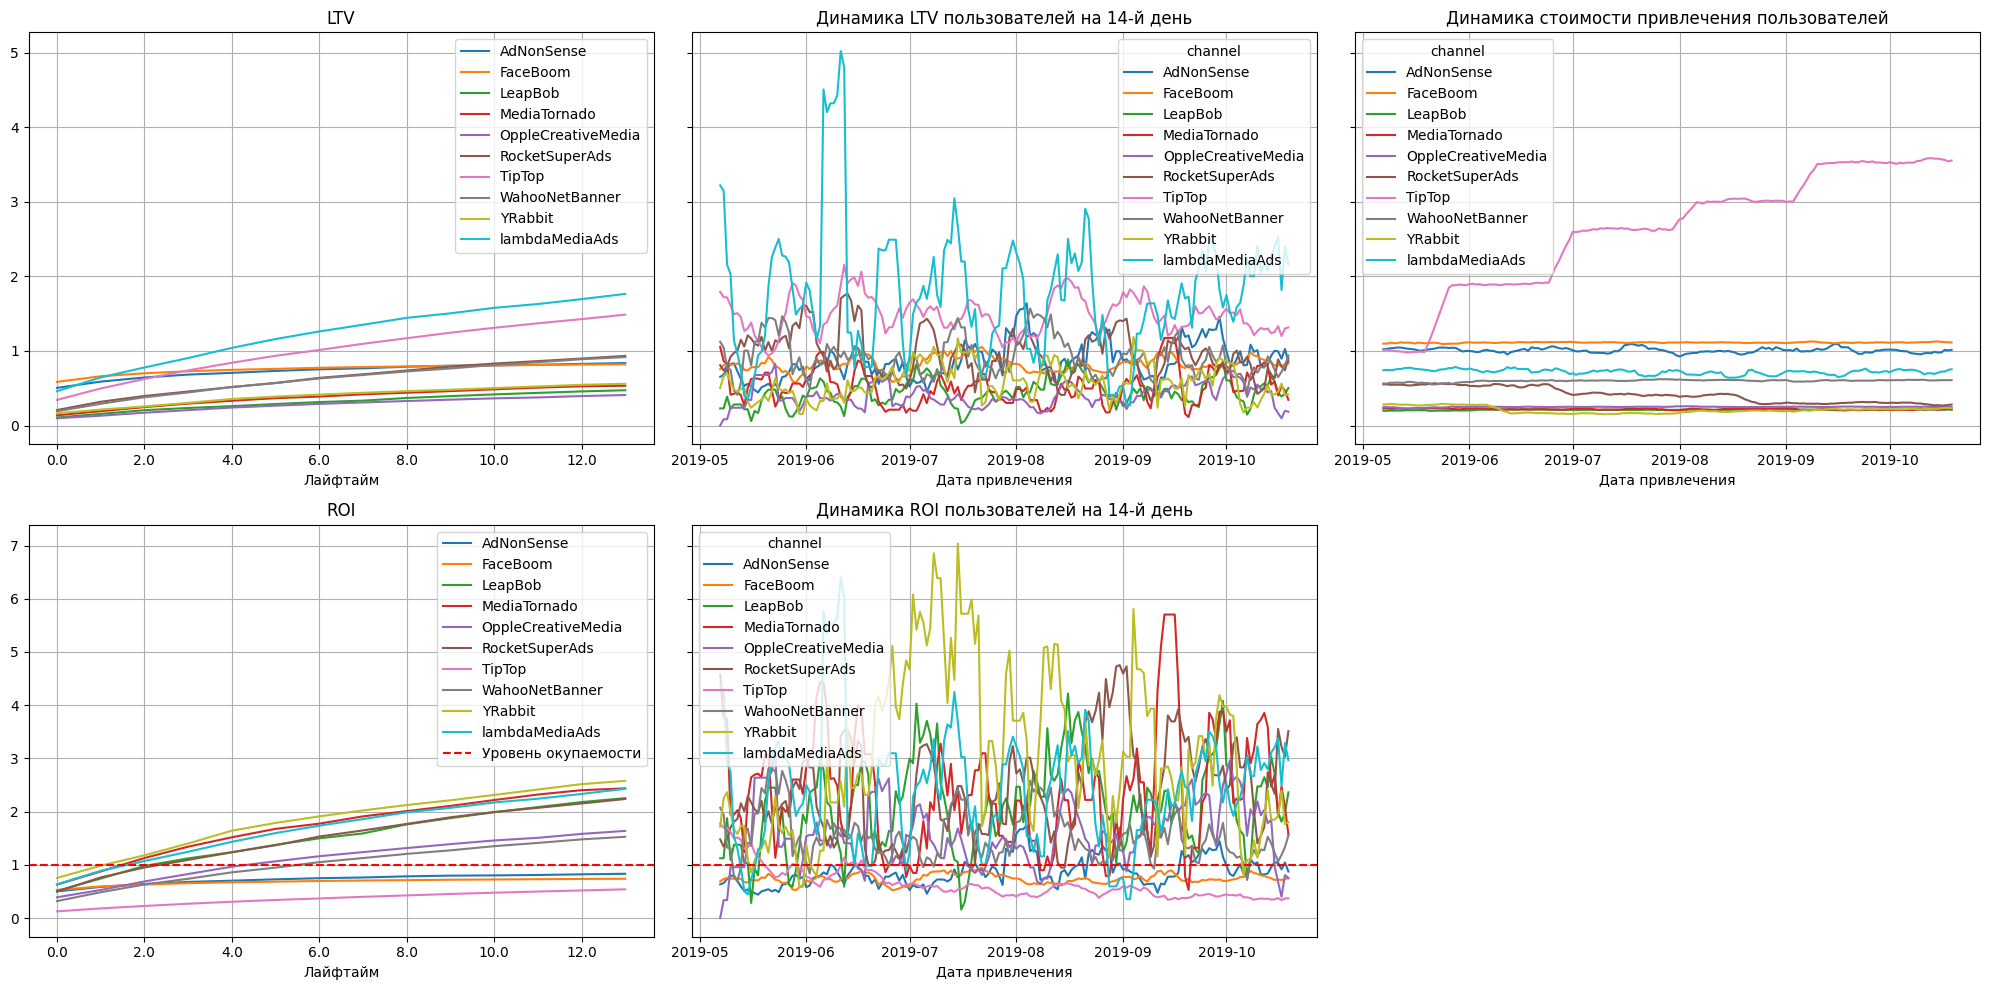

In [42]:
# Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['channel']
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По информации, представленной на данных диаграммах, можно выделить в качестве удачного канала привлечения пользователей lambdaMediaAds - при относительно низких затрат на привлечение пользователей канал приводит пользователей, которые приносят хороший доход, что ведет к высокому уровню окупаемости. Также высоким уровнем окупаемости при низких затратах отличается канал YRabbit. При этом наиболее затратные каналы привлечения TipTop и FaceBoom (имеющие самые высокие показатели CAC) не обеспечивают достижения уровня окупаемости привлеченными пользователями, что видно как на диаграмме ROI, так и на диаграмме динамики ROI.

### Конверсия и удержание пользователей в разрезе каналов привлечения, стран и устройств

**Каналы привлечения:**

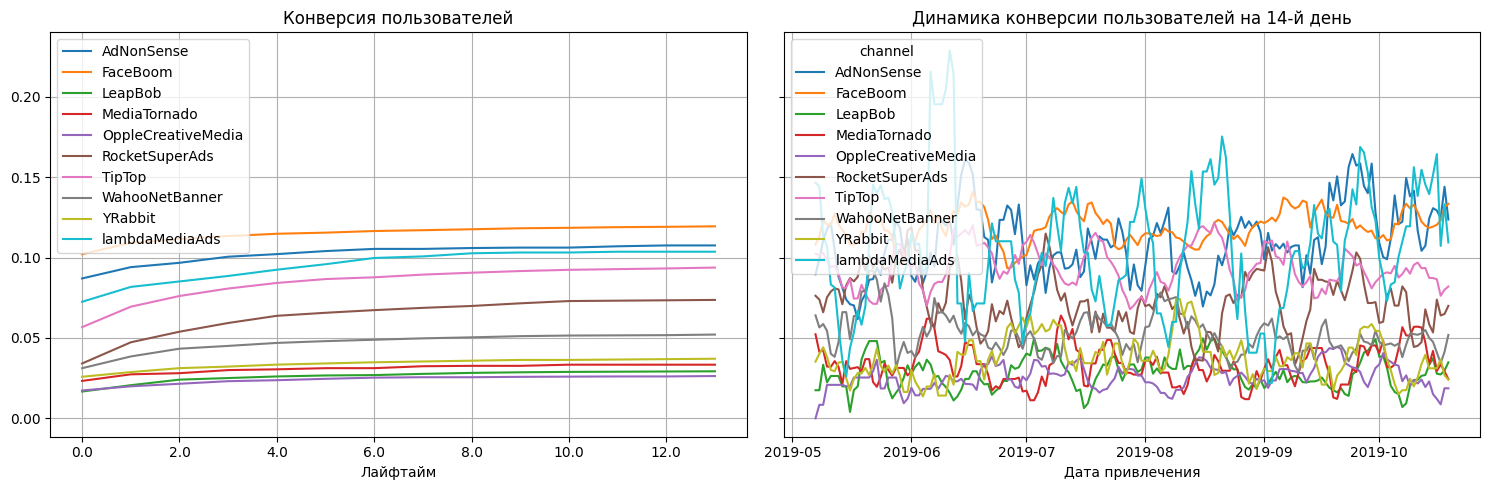

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

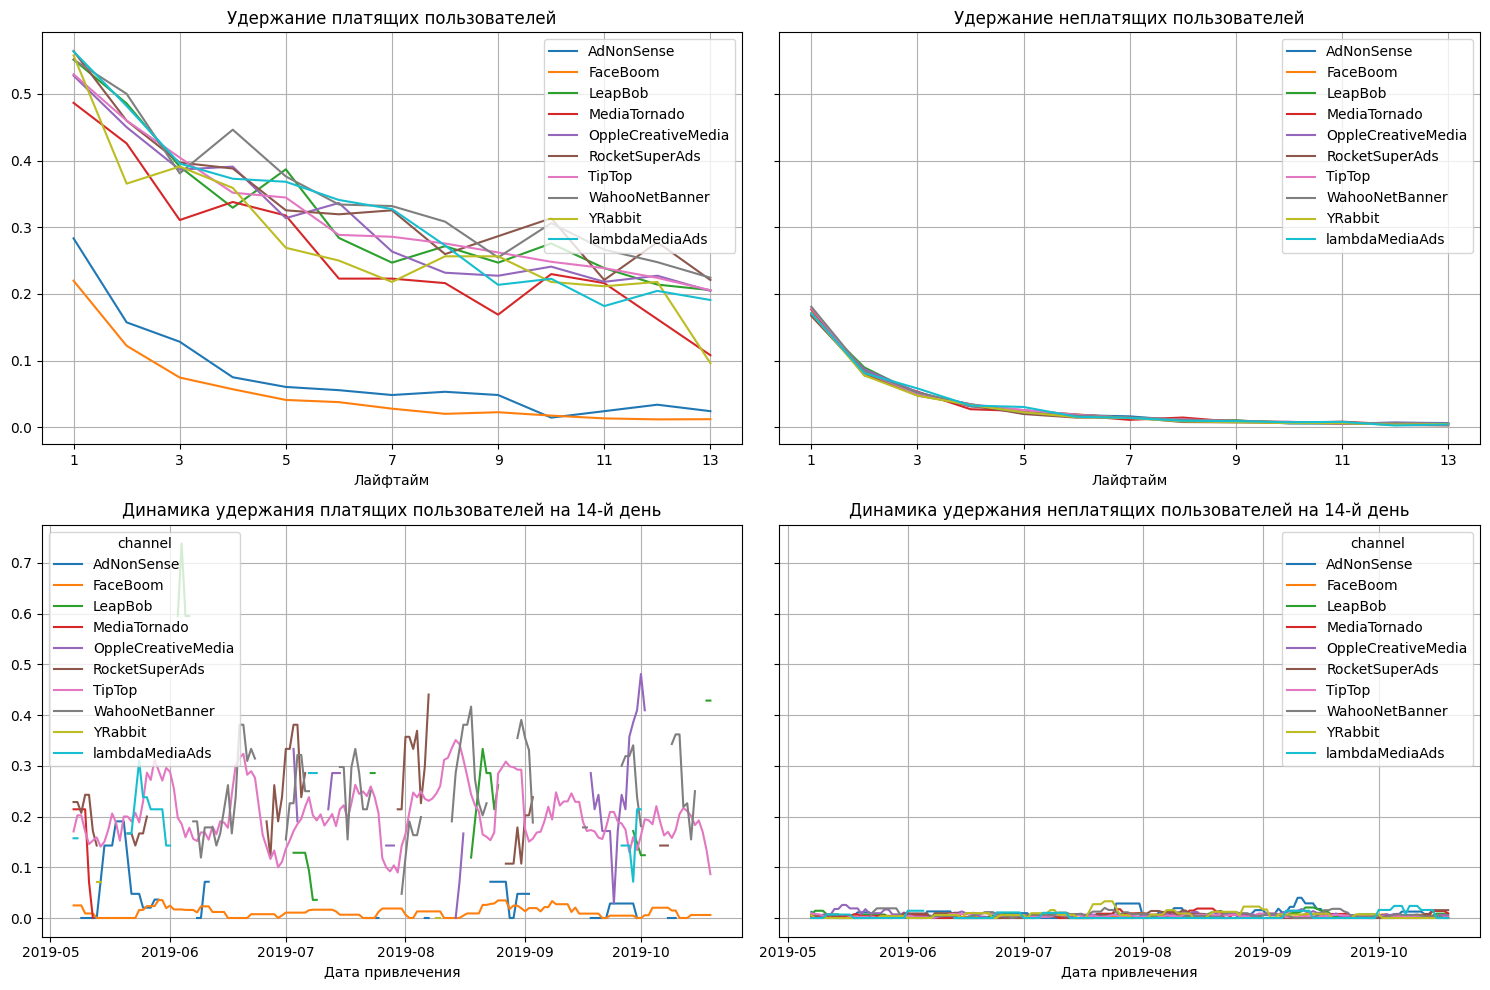

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видно, что каналы FaceBoom и AdNoneSense обеспечивают самую высокую конверсию пользователей, однако обладают самым низким уровнем удержания пользователей. 

**Страны:**

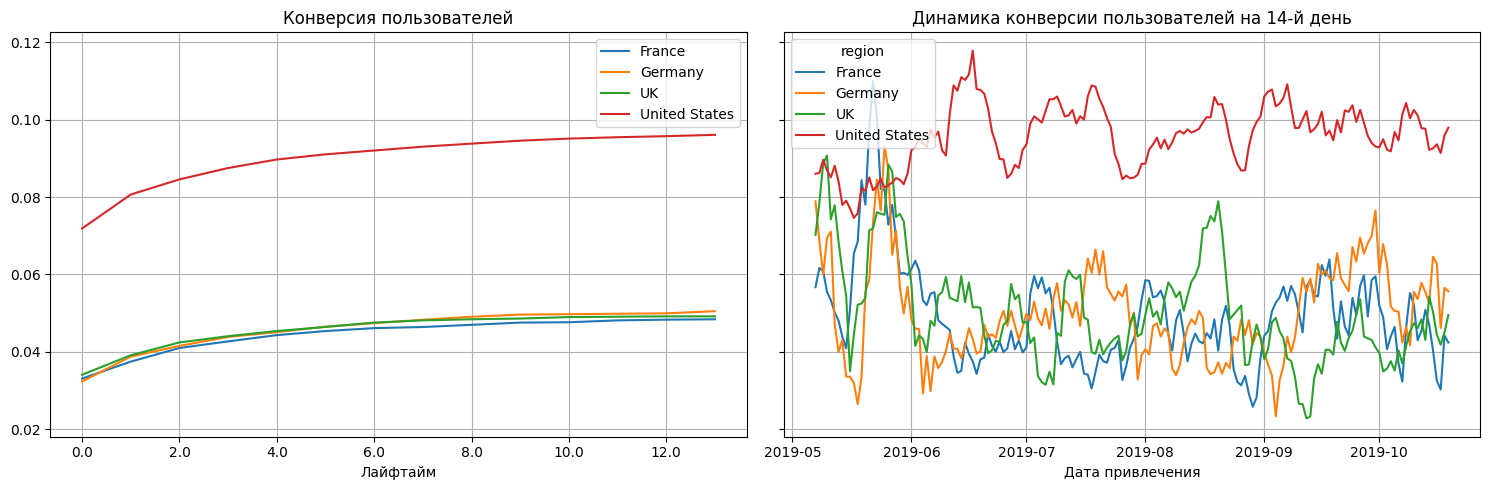

In [45]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

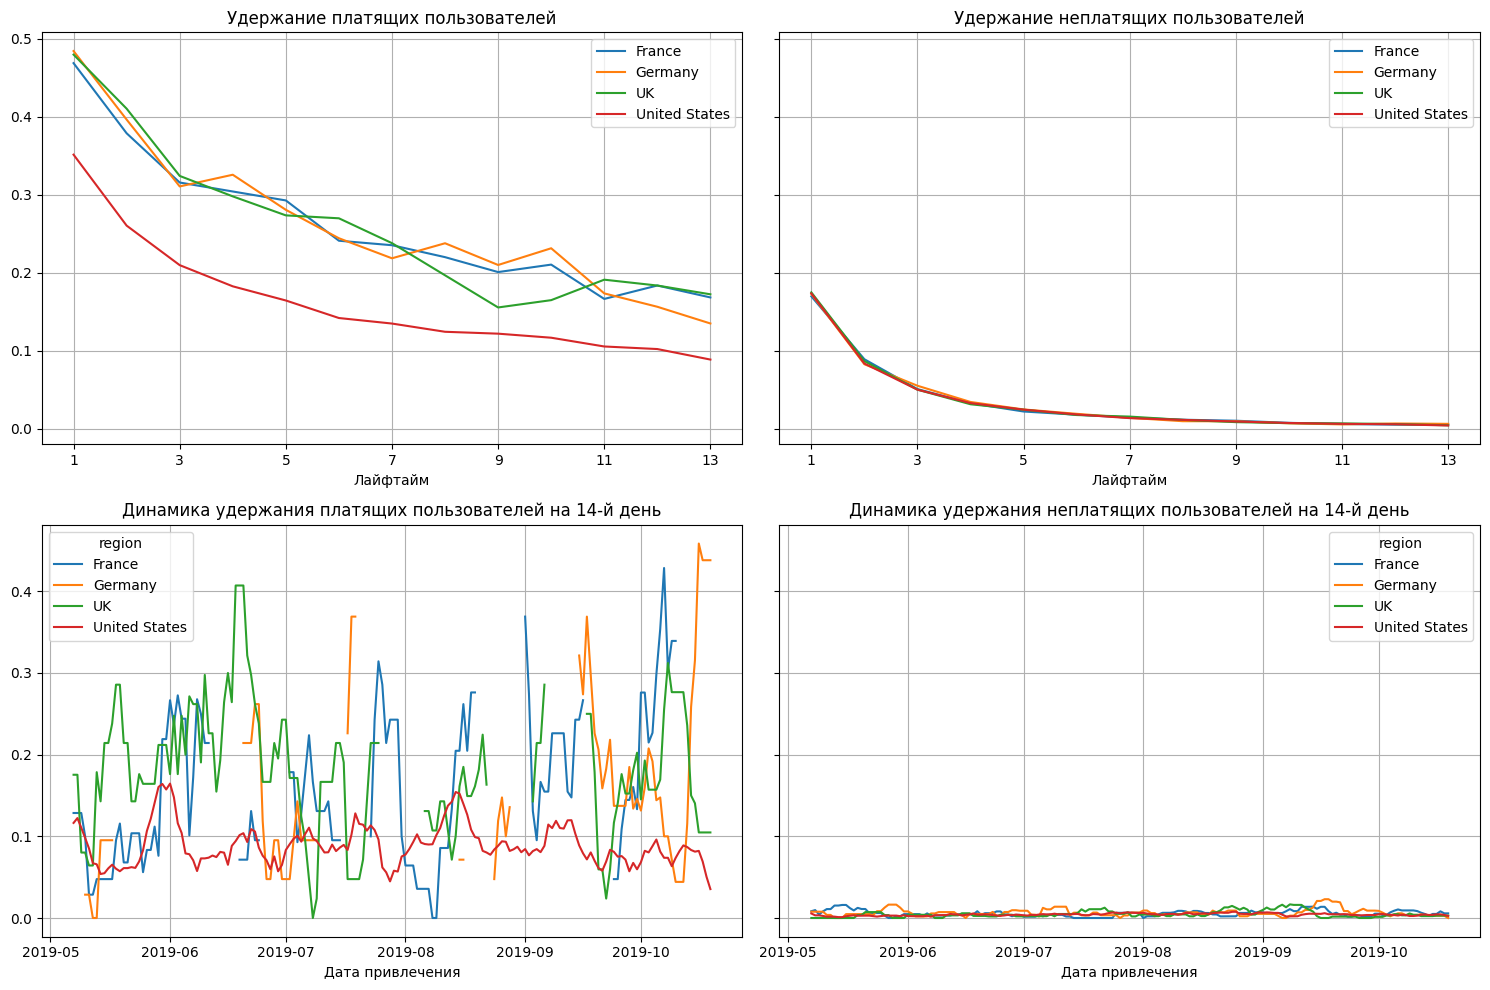

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['region'])

plot_retention(retention_grouped, retention_history, horizon_days) 

Аналогично ситуации с каналами привлечения пользователи из США показывают наибольшую конверсию, однако худшее удержание. 

**Устройства:**

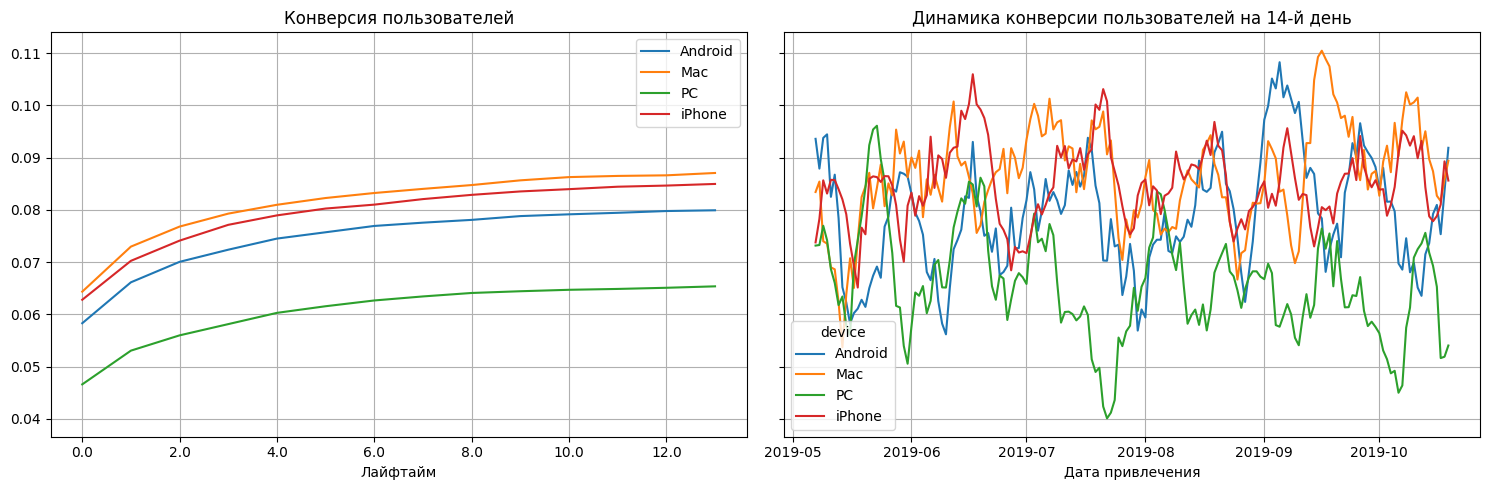

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

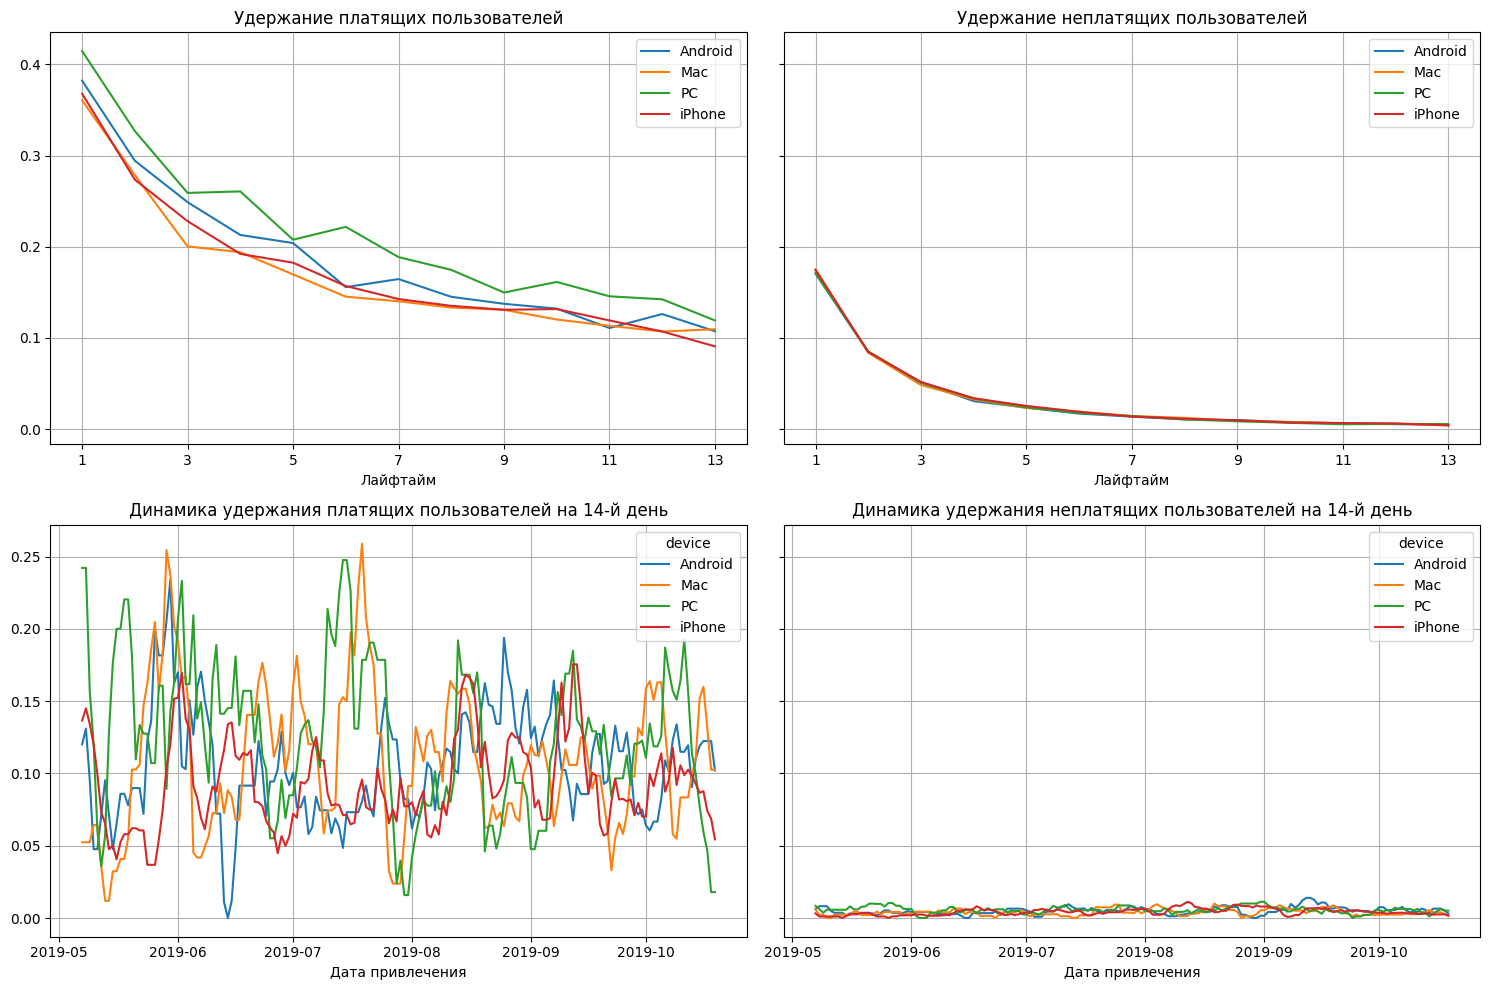

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['device'])

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи PC демонстрируют худшую конверсию, но лучшее удержание. 

В целом, можно сказать, что начиная с июля реклама, направленная на привлечение пользователей, в целом перестала окупаться. Негативное влияние на окупаемость оказала крайне высокая стоимость размещения рекламы в TipTop и FaceBoom. Также не окупается в разрезе устройств привлечение пользователей с платформ iPhone (подавляющее большинство) и Mac, в разрезе стран привлечение пользователей из США (также подавляющее большинство). Существуют каналы, такие как FaceBoom и  AdNonSense, которые обеспечивают высокую конверсию пользователей, однако при этом имеют самые низкие показатели удержания. 

## Общий вывод

Подводя итоги проведенного исследования можно сказать, что исходные данные отличаются полнотой, не содержат пропусков и явных дабликатов. На стадии предобработки данных были изменены типы данных в столбцах с информацией о дате и времени. 

Анализируемый период привлечения пользователей - с 01.05.2019 по 27.10.2019. 

В датафрейме содержатся данные о пользователях:
- из четырех стран - США (большинство пользователей), Великобритания, Франция и Германия;
- использующих устройства iPhone (большинство), Android, Mac и PC. 

При распределении пользователей по каналам привлечения нет линейной зависимости между количеством привлеченных пользователей и плательщиков: наибольшее количество пользователей в целом пришло в приложение органическим путем (по количеству плательщиков - 3 место), однако наибольшее количество платящих пользователей было привлечено через FaceBoom (по количеству всех привлеченных пользователей - 2 место).

Анализ маркетинговых данных показал, что высокие затраты на канал привлечения TipTop (более 50% от всех затрат) приносят лишь коло 13% пользователей (с учетом органически пришедших пользователей) или около 21% (без их учета). Динамика расходов понедельно, помесячно, показатель CAC показывают, что расходы на маркетинг по каналу TipTop крайне высоки, а также имеют тенденцию к быстрому росту, при том, что никакие данные не свидетельствуют об эффективности расходования таких больших средств на данный канал привлечения.

В целом, рекламная комания не окупается по причине высоких затрат на привлечение пользователей по отдельным устройствам (iPhone и Mac), странам (США) и каналам привлечения (TipTop).

Рекомендуется рассмотреть возможность сокращения рекламных компаний на дорогих каналах (TipTop) и их расширения на каналах, недорогих по привлечению пользователей, но имеющих показатель ROI выше 1, например, lambdaMediaAds и YRabbit. Также стоит более детально разобраться, нет ли каких-либо технических причин, из-за которых пользователи из США, а также пользователи Mac и iPhone хорошо конвертируются в пользователей приложения, но быстро уходят. 

Наконец, рекомендуется дополнительно поработать над удержанием пользователей, привлеченных через каналы FaceBoom и AdNonSense, которые показывают высокую конверсию и низкий уровень удержания. Например, можно было бы внедрить какие-то дополнительные акции для этих пользователей, стимулирующие более длительное использование приложения, скидки после определенного количества дней использования приложения. 